In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt



In [21]:
#data_LOB_price1 = pd.read_csv("C:\\Users\\zoec0\\Desktop\\DSMP\\LSTM预测股票价格\\data_LOB_price1.csv")
clean_uob_set01_tapes = pd.read_csv("C:\\Users\\zoec0\\Desktop\\DSMP\\Clean\\Tape\\Clean_UoB_Set01_2025-01-02tapes.csv")

data_LOB_price1['timestamp'] = pd.to_datetime(data_LOB_price1['timestamp'], unit='s')
clean_uob_set01_tapes['Time'] = pd.to_datetime(clean_uob_set01_tapes['Time'], unit='s')

# 以某种合适的频率重采样
data_resampled = data_LOB_price1.resample('1T', on='timestamp').mean()  # 例如，每分钟的平均值
weighted_prices_resampled = clean_uob_set01_tapes.resample('1T', on='Time').mean()

# 合并两个数据集，以时间为键
combined_data = pd.merge_asof(data_resampled, weighted_prices_resampled, left_index=True, right_index=True, direction='nearest')



In [22]:
# 归一化处理
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features = scaler_features.fit_transform(combined_data[['ask_price1', 'bid_price1']])
targets = scaler_target.fit_transform(combined_data[['Weighted_Price']].values.reshape(-1, 1))

# 划分数据集
split_idx = int(0.8 * len(features))
X_train, X_test = features[:split_idx], features[split_idx:]
y_train, y_test = targets[:split_idx], targets[split_idx:]

# 重塑数据
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 模型构建
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, 2)),
    Dropout(0.2),
    LSTM(30, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# 模型评估
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error on Test Set:", mse)
print("Root Mean Squared Error on Test Set:", rmse)



Epoch 1/50


d:\ProgramFiles\Anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.3785 - val_loss: 0.5309
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3232 - val_loss: 0.4372
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2591 - val_loss: 0.3281
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1855 - val_loss: 0.2011
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1035 - val_loss: 0.0798
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0443 - val_loss: 0.0098
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0302 - val_loss: 0.0011
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0287 - val_loss: 0.0055
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0248 - val_loss: 0.0109
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0254 - val_loss: 0.0069
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0222 - val_loss: 0.0044
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0205 - val_loss: 0.0049

In [23]:
# 新数据点预测
ready_to_predict = features[-10:].reshape((10, 1, 2))
new_predictions = model.predict(ready_to_predict)
new_predictions_rescaled = scaler_target.inverse_transform(new_predictions)
print("Predicted Values:", new_predictions_rescaled)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Values: [[283.31635]
 [293.5705 ]
 [292.9287 ]
 [289.8668 ]
 [291.5321 ]
 [288.51758]
 [295.3337 ]
 [288.96027]
 [290.22693]
 [286.54935]]


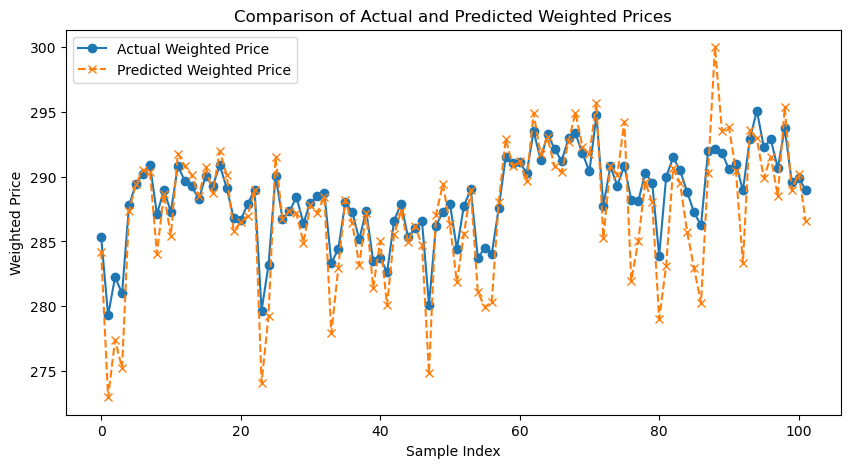

In [24]:
# 可视化实际值与预测值
plt.figure(figsize=(10, 5))
plt.plot(scaler_target.inverse_transform(y_test), label='Actual Weighted Price', marker='o')
plt.plot(scaler_target.inverse_transform(y_pred), label='Predicted Weighted Price', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Weighted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Weighted Price')
plt.legend()
plt.show()

